In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)

n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]

Using control points [0.00000000e+00 0.00000000e+00 4.08389079e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


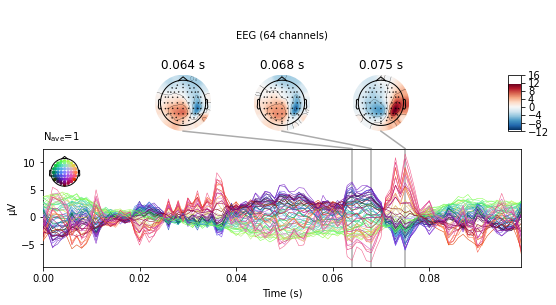

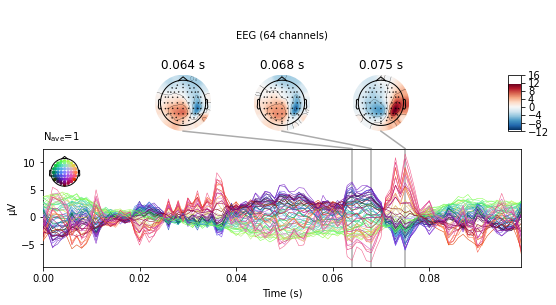

In [6]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(
    number_of_sources=3, 
    extents=(1, 2), 
    duration_of_trial=0.1, 
    target_snr=5)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# MUSIC

In [4]:
# Parameters
n = 6
stop_crit = 0.95

leadfield -= leadfield.mean(axis=0)

_, n_time = y.shape
C = y@y.T
U, D, _  = np.linalg.svd(C, full_matrices=False)
Us = U[:, :n]
Ps = Us@Us.T

mu = np.zeros(n_dipoles)
for p in range(n_dipoles):
    l = leadfield[:, p][:, np.newaxis]
    norm_1 = np.linalg.norm(Ps @ l)
    norm_2 = np.linalg.norm(l)
    mu[p] = norm_1 / norm_2
mu[mu<stop_crit] = 0

dipole_idc = np.where(mu!=0)[0]
x_hat = np.zeros((n_dipoles, n_time))
x_hat[dipole_idc, :] = np.linalg.pinv(leadfield[:, dipole_idc]) @ y

## Plot

In [5]:
stc_ = stc.copy()
stc_.data = x_hat
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'MUSIC', 'title',
               font_size=14)

Using control points [0. 0. 0.]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_5956\1296900930.py:3: RuntimeWarning: All data were zero
  brain = stc_.plot(**pp)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# RAP-MUSIC

In [11]:
# Parameters
n = 10
k = 3
stop_crit = 0.95
alpha = 0.1

leadfield -= leadfield.mean(axis=0)

I = np.identity(n_chans)
C = y @ y.T + alpha * I

dipole_idc = []
B = None
n_time = y.shape[1]
for i in range(k):
    print(i)
    U, D, _= np.linalg.svd(C, full_matrices=False)
    Us = U[:, :n]
    Ps = Us@Us.T

    mu = np.zeros(n_dipoles)
    for p in range(n_dipoles):
        l = leadfield[:, p][:, np.newaxis]
        norm_1 = np.linalg.norm(Ps @ l)
        norm_2 = np.linalg.norm(l)
        mu[p] = norm_1 / norm_2
    dipole_idx = np.argmax(mu)
    dipole_idc.append( dipole_idx )

    if np.max(mu) < stop_crit:
        print("breaking")
        break

    if i == 0:
        B = leadfield[:, dipole_idx][:, np.newaxis]
    else:
        B = np.hstack([B, leadfield[:, dipole_idx][:, np.newaxis]])
    
    Q = I - B @ np.linalg.pinv(B)
    C = Q @ Us

dipole_idc = np.array(dipole_idc)
x_hat = np.zeros((n_dipoles, n_time))
x_hat[dipole_idc, :] = np.linalg.pinv(leadfield[:, dipole_idc]) @ y

0
1
2
breaking


## Plot

Using control points [0.00000000e+00 0.00000000e+00 2.76997998e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


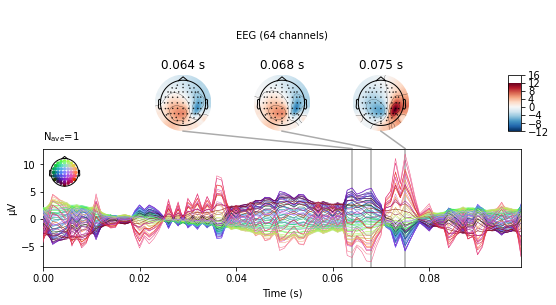

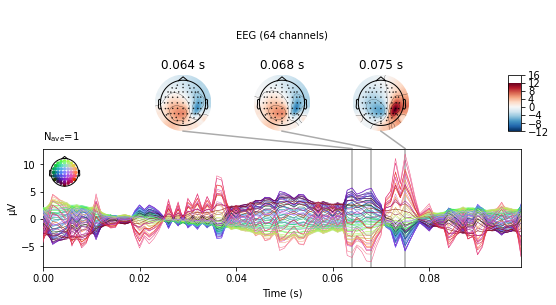

Using control points [0.00000000e+00 0.00000000e+00 2.22210617e-08]


In [12]:
stc_ = stc.copy()
stc_.data = x_hat
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'RAP-MUSIC estimate', 'title',
               font_size=14)
evoked_ = mne.EvokedArray(leadfield@x_hat, evoked.info)
evoked_.plot_joint()

# TRAP-MUSIC

In [8]:
# Parameters
n = 10
k = 3
stop_crit = 0.95
alpha  = 0

leadfield -= leadfield.mean(axis=0)

I = np.identity(n_chans)
C = y @ y.T + alpha * I

dipole_idc = []
B = None
n_time = y.shape[1]
for i in range(k):
    print(i)
    U, D, _= np.linalg.svd(C, full_matrices=False)
    Us = U[:, :n-i]
    Ps = Us@Us.T

    mu = np.zeros(n_dipoles)
    for p in range(n_dipoles):
        l = leadfield[:, p][:, np.newaxis]
        norm_1 = np.linalg.norm(Ps @ l)
        norm_2 = np.linalg.norm(l)
        mu[p] = norm_1 / norm_2
    dipole_idx = np.argmax(mu)
    dipole_idc.append( dipole_idx )

    if np.max(mu) < stop_crit:
        print("breaking")
        break

    if i == 0:
        B = leadfield[:, dipole_idx][:, np.newaxis]
    else:
        B = np.hstack([B, leadfield[:, dipole_idx][:, np.newaxis]])
    
    Q = I - B @ np.linalg.pinv(B)
    C = Q @ Us

dipole_idc = np.array(dipole_idc)
x_hat = np.zeros((n_dipoles, n_time))
x_hat[dipole_idc, :] = np.linalg.pinv(leadfield[:, dipole_idc]) @ y

0
breaking


## Plot

In [9]:
# stc_ = stc.copy()
# stc_.data[dipole_idc, 0] = 1
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, 'RAP-MUSIC', 'title',
#                font_size=14)

stc_ = stc.copy()
stc_.data = x_hat
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'TRAP-MUSIC estimate', 'title',
               font_size=14)

Using control points [0.00000000e+00 0.00000000e+00 2.44811933e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# FINES (something is wrong here)

In [141]:
# Parameters
from invert.util import find_corner
n = 10
K = 16 # number of coarse brain parcels
k = 10 # number of selected eigenvectors from the data

# helper funs
normalize = lambda x: (x.T / np.linalg.norm(x.T, axis=0)).T


leadfield -= leadfield.mean(axis=0)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=K).fit(pos)
membership = kmeans.labels_
regions, region_counts = np.unique(membership, return_counts=True)

Rf = y@y.T

E, s, _ = np.linalg.svd(Rf, full_matrices=False)
Es = E[:, :k]
En = E[:, k:]

V = []
lams = []
lam_idc = []
dipoles = []
for k, region_count in zip(regions, region_counts):
    dipole_idc = np.where(membership==k)[0]
    
    Gl = leadfield[:, dipole_idc]
    Ug, s, _ = np.linalg.svd(Gl, full_matrices=False)
    d = np.where( (np.cumsum(s)/s.sum()) > 0.99)[0][0]
    Ug = Ug[:, :d]

    R = Gl @ Gl.T
    Vk, s, _ = np.linalg.svd(R, full_matrices=False)
    # Find largest eigenvalues
    Dk = np.where( (np.cumsum(s)/s.sum()) > 0.99)[0][0]
    Vk = Vk[:Dk]
    V.append(Vk)

    corrs = abs(normalize(En).T @ normalize(Vk).T)
    fines_vector_idc = np.argsort(np.linalg.norm(corrs, axis=1))[-Dk:]
    # fines_vector_idc = np.argsort(np.max(corrs, axis=1))[-Dk:]
    
    Fk = En[:, fines_vector_idc]
    term = Ug.T@Fk@Fk.T@Ug
    _, eig, _ = np.linalg.svd(term, full_matrices=False)

    # lam_min = np.min(eig)
    # lam_min_idx = dipole_idc[np.argmin(eig)]
    # lams.append(lam_min)
    # lam_idc.append(lam_min_idx)
    found_idx = dipole_idc[np.argmax(np.linalg.norm(eig * term, axis=1))]
    dipoles.append(found_idx)


# dipole_idc = np.array(dipole_idc)
# x_hat = np.zeros((n_dipoles, n_time))
# x_hat[dipole_idc, :] = np.linalg.pinv(leadfield[:, dipole_idc]) @ y

## Plot

In [142]:
dipoles = np.array(dipoles)

x_hat = np.zeros(n_dipoles)
x_hat[dipoles] = 1
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / x_hat.max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Fines estimate', 'title',
               font_size=14)

Using control points [0.00000000e+00 0.00000000e+00 2.28279739e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [125]:
x_hat = np.zeros(n_dipoles)
for k, region_count in zip(regions, region_counts):
    dipole_idc = np.where(membership==k)[0]
    x_hat[dipole_idc] = lams[k]
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / x_hat.max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Fines estimate', 'title',
               font_size=14)

Using control points [0. 0. 1.]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [128]:
lams = np.array(lams)
lam_idc = np.array(lam_idc)

x_hat = np.zeros(n_dipoles)
x_hat[lam_idc] = lams
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / x_hat.max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Fines estimate', 'title',
               font_size=14)

Using control points [0.0000000e+00 0.0000000e+00 4.4883264e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.        0.        0.8760841]


In [114]:
lam_min_idx

array(756, dtype=int64)